In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization
from keras.layers import Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from keras.models import Model, Sequential
from keras.layers.advanced_activations import ReLU
from keras.optimizers import RMSprop
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score

In [28]:
!pip install optuna

  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=28cb679143f24cdb50153b3937bd768bca5c22bf8be339b18b2008dee8c34af9
  Stored in directory: c:\users\srovi\appdata\local\pip\cache\wheels\7f\1a\65\84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [29]:
import optuna

In [2]:
df = pd.read_pickle('subj_merged.pkl')
df.columns
#feat_list = [ 'ecg', 'emg', 'c_eda', 'c_temp', 'resp', 'bvp', 'w_eda', 'w_temp']
#feat_list = [ 'ecg', 'emg', 'c_eda', 'c_temp', 'resp']
feat_list = ['bvp', 'w_eda', 'w_temp']
df = df[df["c_temp"]>0]
df = df[df["label"].isin([1,2,3])]


In [3]:
ids = df["sid"].unique().astype(int)

In [4]:
ids

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17])

In [5]:
def ANN_model(n_input_dim, n_out_dim, num_hidden1, num_hidden2, drop_rate, weight_decay):
    
    # Define network
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(num_hidden1, input_dim=n_input_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(num_hidden2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(n_out_dim, activation='softmax'))
    
    return model

In [6]:
# function to convert class labels to one hot encoding array
def one_hot_enc(r, k):
    new_r = np.zeros((r.shape[0],k))
    for i, val in enumerate(r):
        new_r[i, val-1] = 1
    
    return new_r

In [7]:
def objective(trial):   
    # leave one out method
    test_metrics = []
    
    # tuning parameters
    num_hidden1 = trial.suggest_int("n_units_l0", 8, 10, log=True)
    num_hidden2 = trial.suggest_int("n_units_l1", 4, 8, log=True)
    drop_rate=trial.suggest_float("rate", 0.2, 0.4)
    weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-5, log=True)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    #momentum = trial.suggest_float("momentum", 1e-5, 1e-2, log=True)
    b=trial.suggest_int("batch_size", 32, 128)
    ep=trial.suggest_int("epoch", 5, 15)
        
    for sid in ids:
        df_train = df[df["sid"] != sid]
        df_test = df[df["sid"] == sid]
        x_scaled_train = StandardScaler().fit_transform(df_train[feat_list])
        x_scaled_test = StandardScaler().fit_transform(df_test[feat_list])
        x_train = x_scaled_train
        x_test = x_scaled_test
        y_train = df_train["label"].values.astype(int)
        y_test = df_test["label"].values.astype(int)
        K = len(df_train["label"].unique())
        y_train1 = one_hot_enc(y_train, K)
        y_test1 = one_hot_enc(y_test, K)
        n_input_dim = x_train.shape[1]
        

        model = ANN_model(n_input_dim, K, num_hidden1, num_hidden2, drop_rate, weight_decay)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr==lr), metrics=['accuracy'])
        hist = model.fit(x_train, y_train1, epochs=ep, batch_size=b, verbose=False, validation_data = (x_test, y_test1))


        results = model.evaluate(x_test, y_test1)
        print("Test subject: ", sid)
        print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))
        test_metrics.append((results[0], results[1]))
        
    l = np.array(test_metrics)
    score = l[:,1].mean()
    
    print("len(test_metrics) :", len(test_metrics))

    return score

In [51]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2021-06-13 15:11:33,646] A new study created in memory with name: no-name-33ef9036-a7cc-4f80-98d3-cacc246ba472


266/266 [==============================] - 0s 794us/step - loss: 0.3355 - accuracy: 0.9626
Test subject:  2
Test Loss: 0.336
Test Accuracy: 0.963
270/270 [==============================] - 0s 837us/step - loss: 3.9498 - accuracy: 0.6055
Test subject:  3
Test Loss: 3.950
Test Accuracy: 0.606
271/271 [==============================] - 0s 730us/step - loss: 0.4787 - accuracy: 0.8270
Test subject:  4
Test Loss: 0.479
Test Accuracy: 0.827
278/278 [==============================] - 0s 757us/step - loss: 0.3949 - accuracy: 0.7896
Test subject:  5
Test Loss: 0.395
Test Accuracy: 0.790
276/276 [==============================] - 0s 764us/step - loss: 0.9611 - accuracy: 0.5811
Test subject:  6
Test Loss: 0.961
Test Accuracy: 0.581
275/275 [==============================] - 0s 764us/step - loss: 0.4960 - accuracy: 0.8308
Test subject:  7
Test Loss: 0.496
Test Accuracy: 0.831
277/277 [==============================] - 0s 755us/step - loss: 0.3551 - accuracy: 0.8091
Test subject:  8
Test Loss: 0.355

[I 2021-06-13 15:13:57,244] Trial 0 finished with value: 0.7454176266988118 and parameters: {'n_units_l0': 9, 'n_units_l1': 5, 'rate': 0.2943432983556913, 'weight_decay': 3.4540499483808e-07, 'lr': 9.336504220253229e-05, 'batch_size': 112, 'epoch': 9}. Best is trial 0 with value: 0.7454176266988118.


Test subject:  17
Test Loss: 0.894
Test Accuracy: 0.672
len(test_metrics) : 15
266/266 [==============================] - 0s 781us/step - loss: 0.7724 - accuracy: 0.8180
Test subject:  2
Test Loss: 0.772
Test Accuracy: 0.818
270/270 [==============================] - 0s 717us/step - loss: 1.1165 - accuracy: 0.6128
Test subject:  3
Test Loss: 1.117
Test Accuracy: 0.613
271/271 [==============================] - 0s 756us/step - loss: 0.6263 - accuracy: 0.8276
Test subject:  4
Test Loss: 0.626
Test Accuracy: 0.828
278/278 [==============================] - 0s 861us/step - loss: 0.6019 - accuracy: 0.7223
Test subject:  5
Test Loss: 0.602
Test Accuracy: 0.722
276/276 [==============================] - 0s 736us/step - loss: 1.0707 - accuracy: 0.6515
Test subject:  6
Test Loss: 1.071
Test Accuracy: 0.651
275/275 [==============================] - 0s 694us/step - loss: 0.9934 - accuracy: 0.5396
Test subject:  7
Test Loss: 0.993
Test Accuracy: 0.540
277/277 [==============================] - 0s

[I 2021-06-13 15:18:30,098] Trial 1 finished with value: 0.7559124191602071 and parameters: {'n_units_l0': 10, 'n_units_l1': 4, 'rate': 0.3965785646017962, 'weight_decay': 3.811170549640512e-07, 'lr': 0.0012784350171365813, 'batch_size': 59, 'epoch': 10}. Best is trial 1 with value: 0.7559124191602071.


Test subject:  17
Test Loss: 0.731
Test Accuracy: 0.837
len(test_metrics) : 15
266/266 [==============================] - 0s 885us/step - loss: 0.3788 - accuracy: 0.8865
Test subject:  2
Test Loss: 0.379
Test Accuracy: 0.886
270/270 [==============================] - 0s 703us/step - loss: 1.6199 - accuracy: 0.6965
Test subject:  3
Test Loss: 1.620
Test Accuracy: 0.696
271/271 [==============================] - 0s 716us/step - loss: 0.4968 - accuracy: 0.8282
Test subject:  4
Test Loss: 0.497
Test Accuracy: 0.828
278/278 [==============================] - 0s 1ms/step - loss: 0.3648 - accuracy: 0.7560
Test subject:  5
Test Loss: 0.365
Test Accuracy: 0.756
276/276 [==============================] - 0s 709us/step - loss: 1.0290 - accuracy: 0.6037
Test subject:  6
Test Loss: 1.029
Test Accuracy: 0.604
275/275 [==============================] - 0s 708us/step - loss: 0.6407 - accuracy: 0.6550
Test subject:  7
Test Loss: 0.641
Test Accuracy: 0.655
277/277 [==============================] - 0s 7

[I 2021-06-13 15:21:38,828] Trial 2 finished with value: 0.7457404772440592 and parameters: {'n_units_l0': 8, 'n_units_l1': 5, 'rate': 0.28510470162119084, 'weight_decay': 8.484516471976209e-07, 'lr': 0.0012379054265605185, 'batch_size': 125, 'epoch': 13}. Best is trial 1 with value: 0.7559124191602071.


Test subject:  17
Test Loss: 0.670
Test Accuracy: 0.828
len(test_metrics) : 15
266/266 [==============================] - 0s 701us/step - loss: 0.3746 - accuracy: 0.8050
Test subject:  2
Test Loss: 0.375
Test Accuracy: 0.805
270/270 [==============================] - 0s 681us/step - loss: 2.1585 - accuracy: 0.7782
Test subject:  3
Test Loss: 2.158
Test Accuracy: 0.778
271/271 [==============================] - 0s 703us/step - loss: 0.4959 - accuracy: 0.8278
Test subject:  4
Test Loss: 0.496
Test Accuracy: 0.828
278/278 [==============================] - 0s 718us/step - loss: 0.6978 - accuracy: 0.7338
Test subject:  5
Test Loss: 0.698
Test Accuracy: 0.734
276/276 [==============================] - 0s 690us/step - loss: 1.5897 - accuracy: 0.7120
Test subject:  6
Test Loss: 1.590
Test Accuracy: 0.712
275/275 [==============================] - 0s 910us/step - loss: 0.5718 - accuracy: 0.8308
Test subject:  7
Test Loss: 0.572
Test Accuracy: 0.831
277/277 [==============================] - 0s

[I 2021-06-13 15:23:22,686] Trial 3 finished with value: 0.7658190627892812 and parameters: {'n_units_l0': 10, 'n_units_l1': 4, 'rate': 0.20530457665009125, 'weight_decay': 3.6879689342548564e-07, 'lr': 0.0017712960898782209, 'batch_size': 92, 'epoch': 5}. Best is trial 3 with value: 0.7658190627892812.


Test subject:  17
Test Loss: 0.628
Test Accuracy: 0.829
len(test_metrics) : 15
266/266 [==============================] - 0s 712us/step - loss: 0.7227 - accuracy: 0.8050
Test subject:  2
Test Loss: 0.723
Test Accuracy: 0.805
270/270 [==============================] - 0s 725us/step - loss: 1.6692 - accuracy: 0.7319
Test subject:  3
Test Loss: 1.669
Test Accuracy: 0.732
271/271 [==============================] - 0s 852us/step - loss: 0.4586 - accuracy: 0.8282
Test subject:  4
Test Loss: 0.459
Test Accuracy: 0.828
278/278 [==============================] - 0s 760us/step - loss: 0.4546 - accuracy: 0.7649
Test subject:  5
Test Loss: 0.455
Test Accuracy: 0.765
276/276 [==============================] - 0s 790us/step - loss: 1.1230 - accuracy: 0.7615
Test subject:  6
Test Loss: 1.123
Test Accuracy: 0.761
275/275 [==============================] - 0s 752us/step - loss: 0.5792 - accuracy: 0.7232
Test subject:  7
Test Loss: 0.579
Test Accuracy: 0.723
277/277 [==============================] - 0s

[I 2021-06-13 15:24:50,417] Trial 4 finished with value: 0.7390461226304372 and parameters: {'n_units_l0': 9, 'n_units_l1': 8, 'rate': 0.32376242538419026, 'weight_decay': 1.3446369669195761e-07, 'lr': 5.072264962435793e-05, 'batch_size': 118, 'epoch': 5}. Best is trial 3 with value: 0.7658190627892812.


Test subject:  17
Test Loss: 0.606
Test Accuracy: 0.811
len(test_metrics) : 15
266/266 [==============================] - 0s 671us/step - loss: 0.8500 - accuracy: 0.6803
Test subject:  2
Test Loss: 0.850
Test Accuracy: 0.680
270/270 [==============================] - 0s 730us/step - loss: 3.9677 - accuracy: 0.5860
Test subject:  3
Test Loss: 3.968
Test Accuracy: 0.586
271/271 [==============================] - 0s 720us/step - loss: 0.9415 - accuracy: 0.5299
Test subject:  4
Test Loss: 0.941
Test Accuracy: 0.530
278/278 [==============================] - 0s 656us/step - loss: 0.4434 - accuracy: 0.8313
Test subject:  5
Test Loss: 0.443
Test Accuracy: 0.831
276/276 [==============================] - 0s 680us/step - loss: 1.7770 - accuracy: 0.7052
Test subject:  6
Test Loss: 1.777
Test Accuracy: 0.705
275/275 [==============================] - 0s 722us/step - loss: 0.5786 - accuracy: 0.7589
Test subject:  7
Test Loss: 0.579
Test Accuracy: 0.759
277/277 [==============================] - 0s

[I 2021-06-13 15:32:28,147] Trial 5 finished with value: 0.697433598836263 and parameters: {'n_units_l0': 9, 'n_units_l1': 4, 'rate': 0.2016850184187539, 'weight_decay': 9.026544000724536e-07, 'lr': 0.004788532764902405, 'batch_size': 49, 'epoch': 15}. Best is trial 3 with value: 0.7658190627892812.


Test subject:  17
Test Loss: 1.005
Test Accuracy: 0.519
len(test_metrics) : 15
266/266 [==============================] - 0s 741us/step - loss: 0.5549 - accuracy: 0.7915
Test subject:  2
Test Loss: 0.555
Test Accuracy: 0.791
270/270 [==============================] - 0s 740us/step - loss: 1.9253 - accuracy: 0.7326
Test subject:  3
Test Loss: 1.925
Test Accuracy: 0.733
271/271 [==============================] - 0s 777us/step - loss: 0.9982 - accuracy: 0.5349
Test subject:  4
Test Loss: 0.998
Test Accuracy: 0.535
278/278 [==============================] - 0s 720us/step - loss: 0.7921 - accuracy: 0.6526
Test subject:  5
Test Loss: 0.792
Test Accuracy: 0.653
276/276 [==============================] - 0s 714us/step - loss: 1.5180 - accuracy: 0.6569
Test subject:  6
Test Loss: 1.518
Test Accuracy: 0.657
275/275 [==============================] - 0s 726us/step - loss: 0.5838 - accuracy: 0.8308
Test subject:  7
Test Loss: 0.584
Test Accuracy: 0.831
277/277 [==============================] - 0s

[I 2021-06-13 15:37:32,741] Trial 6 finished with value: 0.7589905619621277 and parameters: {'n_units_l0': 8, 'n_units_l1': 5, 'rate': 0.3504782082829059, 'weight_decay': 2.6504917882756348e-08, 'lr': 2.0829837900951707e-05, 'batch_size': 73, 'epoch': 15}. Best is trial 3 with value: 0.7658190627892812.


Test subject:  17
Test Loss: 0.651
Test Accuracy: 0.837
len(test_metrics) : 15
266/266 [==============================] - 0s 725us/step - loss: 1.2261 - accuracy: 0.8058
Test subject:  2
Test Loss: 1.226
Test Accuracy: 0.806
270/270 [==============================] - 0s 714us/step - loss: 3.5082 - accuracy: 0.6893
Test subject:  3
Test Loss: 3.508
Test Accuracy: 0.689
271/271 [==============================] - 0s 772us/step - loss: 0.5196 - accuracy: 0.8282
Test subject:  4
Test Loss: 0.520
Test Accuracy: 0.828
278/278 [==============================] - 0s 724us/step - loss: 0.5547 - accuracy: 0.7528
Test subject:  5
Test Loss: 0.555
Test Accuracy: 0.753
276/276 [==============================] - 0s 704us/step - loss: 3.6132 - accuracy: 0.6997
Test subject:  6
Test Loss: 3.613
Test Accuracy: 0.700
275/275 [==============================] - 0s 742us/step - loss: 0.6647 - accuracy: 0.7861
Test subject:  7
Test Loss: 0.665
Test Accuracy: 0.786
277/277 [==============================] - 0s

[I 2021-06-13 15:41:37,449] Trial 7 finished with value: 0.7143714904785157 and parameters: {'n_units_l0': 9, 'n_units_l1': 7, 'rate': 0.22194093540852697, 'weight_decay': 6.647756234009619e-08, 'lr': 0.001656828385129499, 'batch_size': 73, 'epoch': 11}. Best is trial 3 with value: 0.7658190627892812.


Test subject:  17
Test Loss: 0.843
Test Accuracy: 0.623
len(test_metrics) : 15
266/266 [==============================] - 0s 709us/step - loss: 0.7117 - accuracy: 0.9395
Test subject:  2
Test Loss: 0.712
Test Accuracy: 0.940
270/270 [==============================] - 0s 755us/step - loss: 1.3924 - accuracy: 0.7383
Test subject:  3
Test Loss: 1.392
Test Accuracy: 0.738
271/271 [==============================] - 0s 770us/step - loss: 0.5327 - accuracy: 0.8282
Test subject:  4
Test Loss: 0.533
Test Accuracy: 0.828
278/278 [==============================] - 0s 705us/step - loss: 0.6136 - accuracy: 0.7382
Test subject:  5
Test Loss: 0.614
Test Accuracy: 0.738
276/276 [==============================] - 0s 721us/step - loss: 1.2769 - accuracy: 0.6761
Test subject:  6
Test Loss: 1.277
Test Accuracy: 0.676
275/275 [==============================] - 0s 758us/step - loss: 0.6719 - accuracy: 0.8296
Test subject:  7
Test Loss: 0.672
Test Accuracy: 0.830
277/277 [==============================] - 0s

[I 2021-06-13 15:45:18,793] Trial 8 finished with value: 0.7351383169492086 and parameters: {'n_units_l0': 8, 'n_units_l1': 5, 'rate': 0.2682417028161105, 'weight_decay': 4.3000599140414746e-08, 'lr': 3.0464919629671597e-05, 'batch_size': 94, 'epoch': 13}. Best is trial 3 with value: 0.7658190627892812.


Test subject:  17
Test Loss: 0.637
Test Accuracy: 0.759
len(test_metrics) : 15
266/266 [==============================] - 0s 779us/step - loss: 0.6935 - accuracy: 0.8965
Test subject:  2
Test Loss: 0.694
Test Accuracy: 0.897
270/270 [==============================] - 0s 786us/step - loss: 1.3045 - accuracy: 0.6619
Test subject:  3
Test Loss: 1.304
Test Accuracy: 0.662
271/271 [==============================] - 0s 831us/step - loss: 0.5122 - accuracy: 0.8072
Test subject:  4
Test Loss: 0.512
Test Accuracy: 0.807
278/278 [==============================] - 0s 864us/step - loss: 1.3481 - accuracy: 0.6872
Test subject:  5
Test Loss: 1.348
Test Accuracy: 0.687
276/276 [==============================] - 0s 791us/step - loss: 1.9401 - accuracy: 0.6501
Test subject:  6
Test Loss: 1.940
Test Accuracy: 0.650
275/275 [==============================] - 0s 786us/step - loss: 0.5520 - accuracy: 0.8308
Test subject:  7
Test Loss: 0.552
Test Accuracy: 0.831
277/277 [==============================] - 0s

[I 2021-06-13 15:49:25,906] Trial 9 finished with value: 0.7245206594467163 and parameters: {'n_units_l0': 9, 'n_units_l1': 5, 'rate': 0.37735926046117785, 'weight_decay': 4.77594266480736e-06, 'lr': 0.00012714869569853952, 'batch_size': 78, 'epoch': 12}. Best is trial 3 with value: 0.7658190627892812.


Test subject:  17
Test Loss: 7.564
Test Accuracy: 0.522
len(test_metrics) : 15


In [24]:
l = np.array(test_metrics)

In [26]:
l[:,1].mean()

0.7388005753358206

In [27]:
l[:,1]

array([0.97312587, 0.67235178, 0.82817554, 0.82205683, 0.72638512,
       0.83075523, 0.77704841, 0.81144744, 0.79084319, 0.83903915,
       0.7218104 , 0.46127078, 0.80799371, 0.5972535 , 0.42245167])

In [47]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 5
Best trial:
  Value: 0.7413948814074198
  Params: 
    n_units_l0: 10
    n_units_l1: 6
    rate: 0.36825153281114464
    weight_decay: 9.117076288736861e-06
    lr: 0.008638688848650435
    batch_size: 56
    epoch: 12


In [8]:
def train_model(num_hidden1, num_hidden2, drop_rate, weight_decay, lr, b, ep):   
    # leave one out method
    test_metrics = []
        
    for sid in ids:
        df_train = df[df["sid"] != sid]
        df_test = df[df["sid"] == sid]
        x_scaled_train = StandardScaler().fit_transform(df_train[feat_list])
        x_scaled_test = StandardScaler().fit_transform(df_test[feat_list])
        x_train = x_scaled_train
        x_test = x_scaled_test
        y_train = df_train["label"].values.astype(int)
        y_test = df_test["label"].values.astype(int)
        K = len(df_train["label"].unique())
        y_train1 = one_hot_enc(y_train, K)
        y_test1 = one_hot_enc(y_test, K)
        n_input_dim = x_train.shape[1]
        

        model = ANN_model(n_input_dim, K, num_hidden1, num_hidden2, drop_rate, weight_decay)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr==lr), metrics=['accuracy'])
        hist = model.fit(x_train, y_train1, epochs=ep, batch_size=b, verbose=False)


        results = model.evaluate(x_test, y_test1)
        y_pred = model.predict(x_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test1, axis=1)

        #acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print("Test subject: ", sid)
        #print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))
        print("Test accuracy: %.3f\nTest f1-score: %.3f" %(results[1],  f1))
        test_metrics.append([sid, results[1], f1])
        
    l = np.array(test_metrics)
    #score = l[:,1].mean()
    
    print("len(test_metrics) :", len(test_metrics))

    return l

In [9]:
model = ANN_model(8, 3, 8, 8, 0.3, weight_decay=1e-6)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [11]:
s = train_model (8, 8, 0.3, weight_decay=1e-6, lr=0.001, b=92, ep=10)

266/266 [==============================] - 0s 715us/step - loss: 0.4656 - accuracy: 0.8020
Test subject:  2
Test accuracy: 0.802
Test f1-score: 0.729
270/270 [==============================] - 0s 735us/step - loss: 6.6303 - accuracy: 0.6995
Test subject:  3
Test accuracy: 0.700
Test f1-score: 0.634
271/271 [==============================] - 0s 790us/step - loss: 0.4912 - accuracy: 0.8173
Test subject:  4
Test accuracy: 0.817
Test f1-score: 0.745
278/278 [==============================] - 0s 767us/step - loss: 0.4909 - accuracy: 0.7422
Test subject:  5
Test accuracy: 0.742
Test f1-score: 0.678
276/276 [==============================] - 0s 733us/step - loss: 0.7826 - accuracy: 0.6299
Test subject:  6
Test accuracy: 0.630
Test f1-score: 0.582
275/275 [==============================] - 0s 688us/step - loss: 1.7643 - accuracy: 0.7507
Test subject:  7
Test accuracy: 0.751
Test f1-score: 0.680
277/277 [==============================] - 0s 762us/step - loss: 0.8659 - accuracy: 0.8128
Test subj

In [154]:
s

array([[ 2.        ,  0.96817541,  0.96838627],
       [ 3.        ,  0.61747301,  0.55827781],
       [ 4.        ,  0.82817554,  0.75415292],
       [ 5.        ,  0.77695084,  0.74055583],
       [ 6.        ,  0.73978204,  0.68710593],
       [ 7.        ,  0.83075523,  0.75760498],
       [ 8.        ,  0.81846988,  0.74999931],
       [ 9.        ,  0.79574418,  0.7313066 ],
       [10.        ,  0.59090906,  0.5498241 ],
       [11.        ,  0.57829159,  0.50479912],
       [13.        ,  0.81615007,  0.7438027 ],
       [14.        ,  0.61068702,  0.54932387],
       [15.        ,  0.78750563,  0.71947172],
       [16.        ,  0.57507879,  0.53397181],
       [17.        ,  0.83589631,  0.76562267]])

In [35]:
tf.random.set_seed(10)

In [15]:
np.std(s[:,2])

0.13161700874973795

In [16]:
np.std(s[:,1])

0.12687838636320647

In [13]:
np.mean(s[:,2])

0.6034107385485773

In [12]:
np.mean(s[:,1])

0.6739250500996907

In [34]:
np.std(s[:,2])

0.08078760513947895

In [30]:
np.mean(s[:,2])

0.7096994956334431

In [20]:
s[:,0].astype(int)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17])

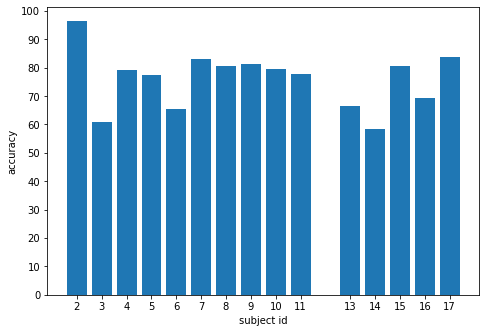

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(s[:,0].astype(int),s[:,2]*100)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_xticks(s[:,0].astype(int))
ax.set_ylabel('accuracy')
ax.set_xlabel('subject id')
plt.show()